On peut récupérer les données depuis la bdd grace à l'api de dbhub.io

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import requests
import json

In [ ]:
# URL /v1/query
# Run a SQLite query on a database
# Parameters (POST)
# apikey # Your API key.
# dbowner # The owner of the database
# dbname # The name of the database
# sql # The SQL query, Base64 encoded

files = {
    'apikey': (None, '2Dnf3U9w2mugDcbrWn31rxuVxSU'),
    'dbowner': (None, 's.guyennon'),
    'dbname': (None, 'db-wish.db'),
    'sql' : (None,"c2VsZWN0ICogCmZyb20gcHJvZHVjdCAKbGVmdCBqb2luIG1lcmNoYW50IG9uIHByb2R1Y3QubWVyY2hhbnRfaWQ9bWVyY2hhbnQubWVyY2hhbnRfaWQ=")
}
r = requests.post('https://api.dbhub.io/v1/query', files=files)

# La réponse est un peu encodée de façon bancale, l'API est encore en dvpmt

dic = json.loads(r.text)
df = pd.DataFrame(dic)

# on récupère les noms des colonnes

nom_col = []
for i in range(len(df.columns)) : 
    nom = df[i][0]["Name"]
    nom_col.append(nom)

df.columns = nom_col

# on récupere les valeurs de chaque case du df

for i in range(19) : 
    df.iloc[:,i] = df.iloc[:,i].apply(lambda x : x["Value"])

# doulon de merchant id du au join sql

df = df.loc[:,~df.columns.duplicated()]

# correction de type



In [ ]:
for i in df.columns :
  try :
    df[i] = df[i].astype(float)
  except : 
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21437 entries, 0 to 21436
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title_orig                   21437 non-null  object 
 1   discount_price               21437 non-null  float64
 2   retail_price                 21437 non-null  float64
 3   rating                       21437 non-null  float64
 4   rating_count                 21437 non-null  float64
 5   product_color                21437 non-null  float64
 6   product_variation_inventory  21437 non-null  float64
 7   shipping_option_price        21437 non-null  float64
 8   shipping_is_express          21437 non-null  float64
 9   has_urgency_banner           21437 non-null  float64
 10  inventory_total              21437 non-null  float64
 11  merchant_id                  21437 non-null  float64
 12  product_id                   21437 non-null  float64
 13  discount_amount 

On va ensuite opérer à un cut des valeurs extremes pour avoir un set de donnée plus cohérent

In [ ]:
for x in ['rating','rating_count','shipping_option_price','inventory_total','merchant_rating_count','merchant_rating']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [ ]:
df = df.dropna(axis=0)

 Visuel du taux de succès d'un produit en fonction du pourcentage de discount appliqué. On prend note que les produits qui ont le plus de succès ont un prix discount d'environ 30%. 

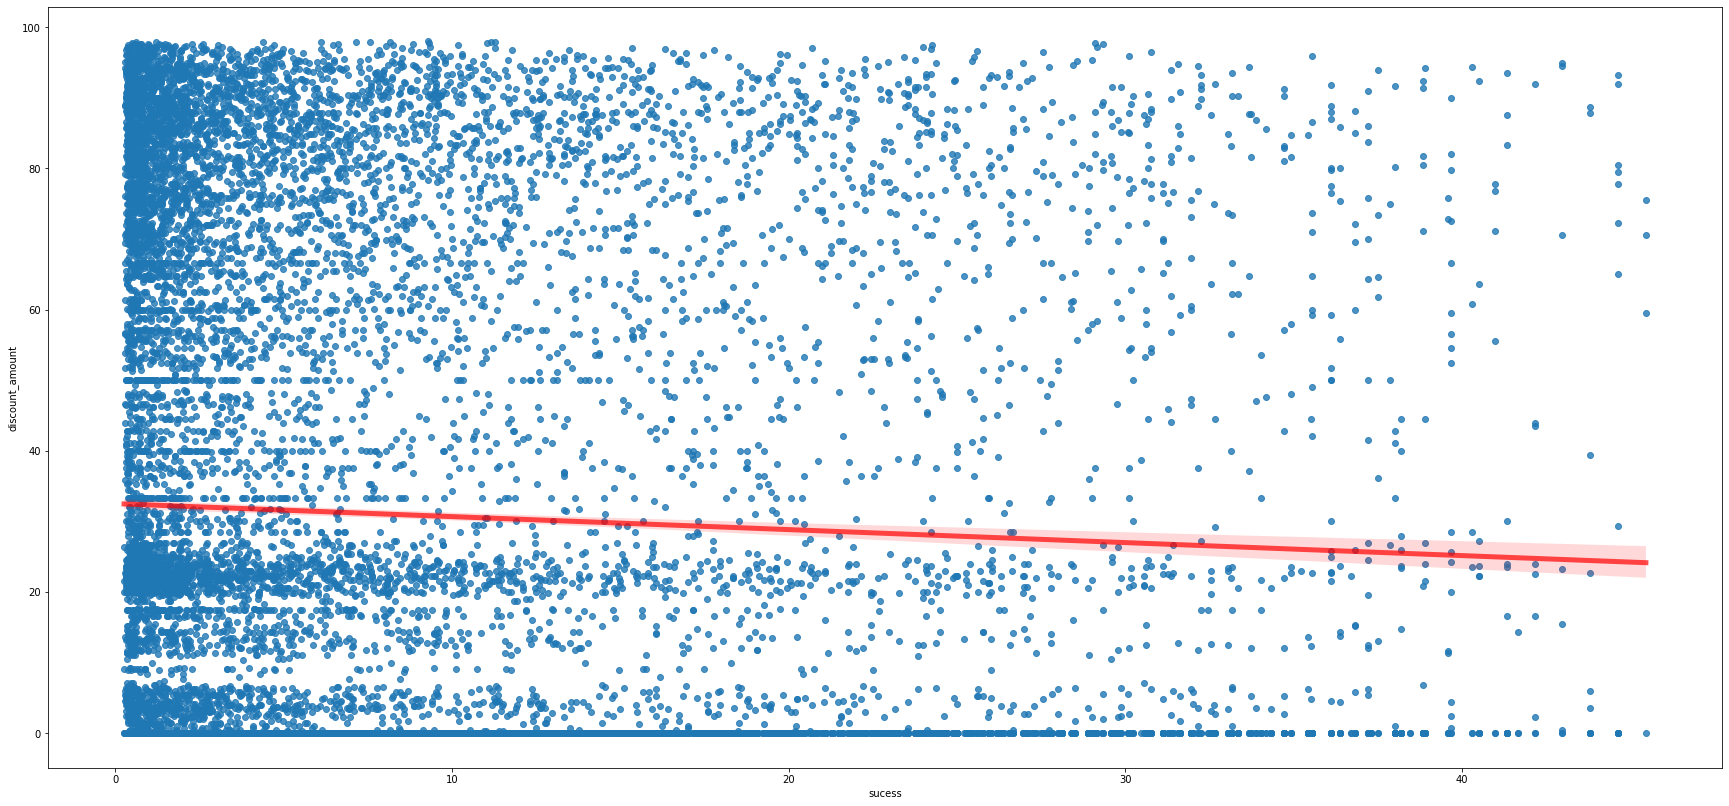

In [ ]:
plt.figure(figsize=(30,14))
sns.regplot(x=df["sucess"], y=df["discount_amount"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

Graphique de la proportion des pourcentages de discount. 

On remarque qu'une grande majorité n'en ont pas. Ensuite le % des discounts les plus représentés sont les 20/30% et 80/90++ % . 

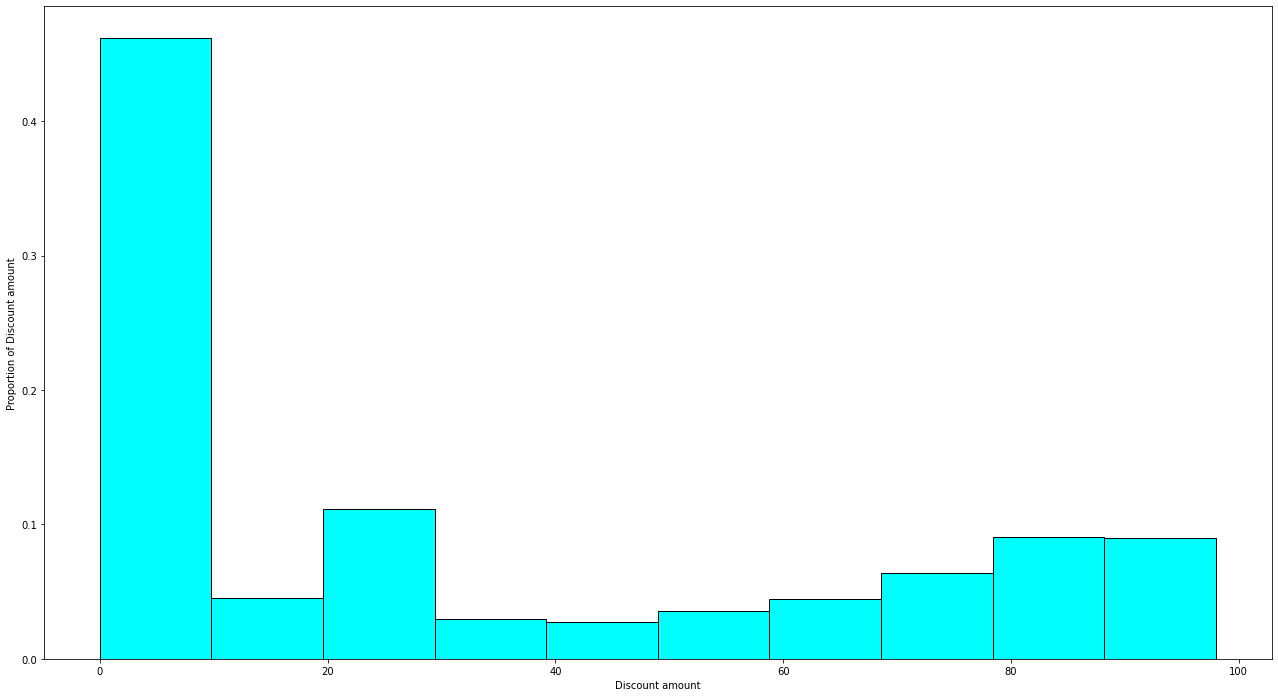

In [ ]:
plt.figure(figsize=(22,12))
weights = np.ones_like(df['discount_amount'])/df['discount_amount'].count()
plt.hist(df['discount_amount'] , bins=10, weights = weights, facecolor = 'cyan',
         edgecolor = 'black', linewidth=1)
plt.xlabel('Discount amount')
plt.ylabel('Proportion of Discount amount')
plt.show()

Graphique de proportion des produits qui ont du succès. 

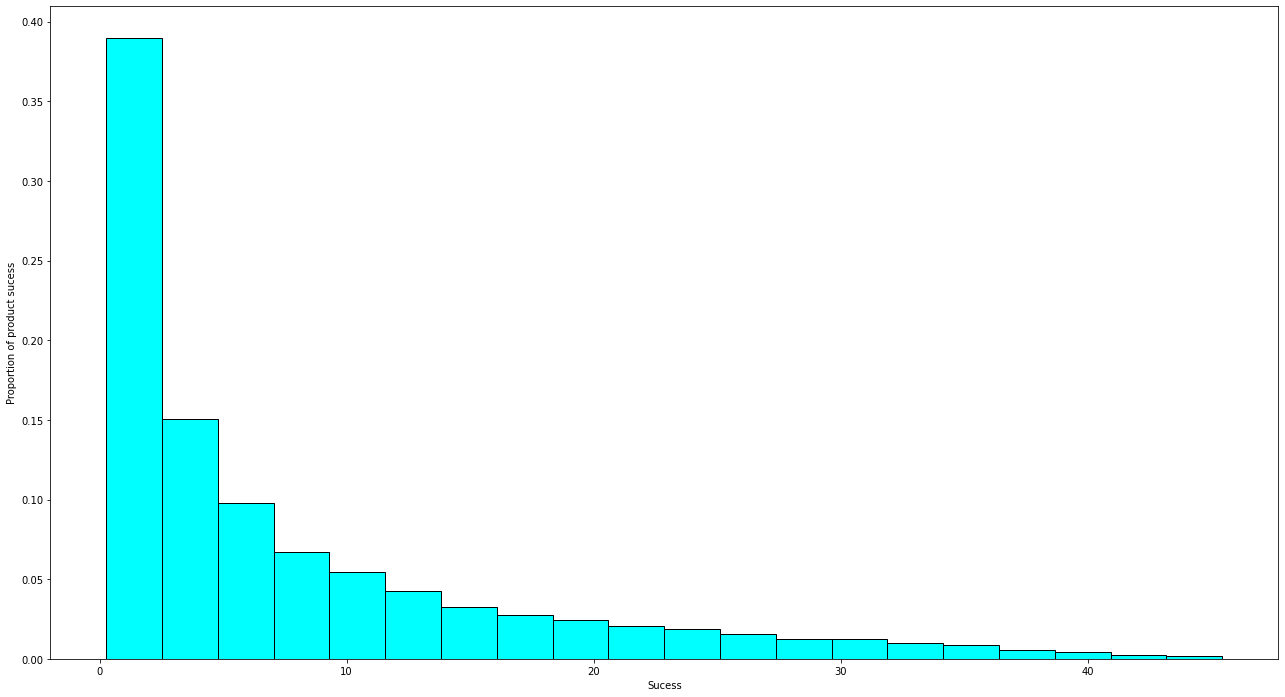

In [ ]:
plt.figure(figsize=(22,12))
weights = np.ones_like(df['sucess'])/df['sucess'].count()
plt.hist(df['sucess'] , bins=20, weights = weights, facecolor = 'cyan',
         edgecolor = 'black', linewidth=1)
plt.xlabel('Sucess')
plt.ylabel('Proportion of product sucess')
plt.show()

In [ ]:
trace1 = go.Violin(y=df["retail_price"],name='retail_price')
trace2 = go.Violin(y=df["discount_price"],name='discount_price')
fig=go.Figure([trace1, trace2])
fig.update_layout(
title='Comparing between retail price and discount price',
yaxis_title='Price')
fig.show()

Pour analyser en un coup d'oeil tout le dataframe, on affiche une heatmap de correlation.

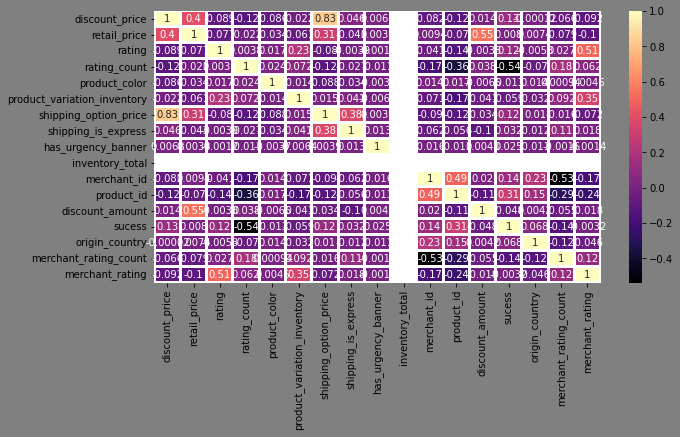

In [ ]:
plt.figure(figsize = [10, 5], clear = True, facecolor = 'grey')
sns.heatmap(df.corr(), annot = True, square = False, linewidths = 2,
            linecolor = "white", cmap = "magma");

On attaque le montage du modèle de ML !Linear Regression.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [ ]:
# X = df.drop(['sucess' ,'title_orig'], axis = 'columns')
# V2 en dropant les colonnes et rating count
X = df.drop(['sucess' ,'title_orig',"rating_count"], axis = 'columns')
y = df.sucess

In [ ]:
X, y = np.array(X), np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
yhat = lr.predict(X_test)

In [ ]:
lr.score(X_test, y_test)

0.1417545785427622

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold

In [ ]:
# X = df.drop(['title_orig','sucess' ], axis = 'columns')
X = df.drop(['sucess' ,'title_orig',"rating_count"], axis = 'columns')
y = df.sucess
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.25, random_state=42)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = Ridge()
model.fit(X_train,y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error,r2_score
print(r2_score(y_test,y_pred))

0.16309240333040242


In [ ]:
#define parameters

param = {
    'alpha':[.0001, 0.001,0.01, 0.01,1],
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

In [ ]:
#define model
model = Ridge()

# define search
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_sc, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.16040120060376262
Best Hyperparameters: {'alpha': 0.001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



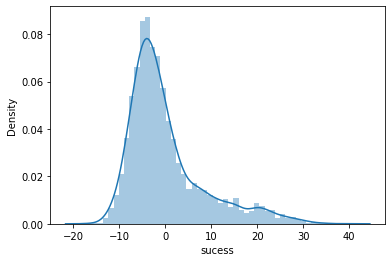

In [ ]:
sns.distplot(y_test-y_pred)

SGD Regressor 

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale

In [ ]:
sgdr = SGDRegressor()

In [ ]:
sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("R-squared:", score)

R-squared: 0.16032574735445315


In [ ]:
cv_score = cross_val_score(sgdr, X, y, cv = 5)
print("CV mean score: ", cv_score.mean())

CV mean score:  -2.3570292429496605e+31


LassoCV

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.16316371171295507


ElasticNetCV

In [ ]:
from sklearn.linear_model import ElasticNetCV

In [ ]:
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=0)

In [ ]:
regr.score(X_test, y_test)

0.16321060823301092

PassiveAggressiveRegressor

In [ ]:
from sklearn.linear_model import PassiveAggressiveRegressor

In [ ]:
regr = PassiveAggressiveRegressor(max_iter=100, random_state=0, tol=1e-3)
regr.fit(X_train, y_train)

PassiveAggressiveRegressor(max_iter=100, random_state=0)

In [ ]:
regr.score(X_test, y_test)

-0.7298234384517857

X Grad boost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=2)
clf.fit(X_test,y_test)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[14:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2748200739507647
{'max_depth': 2, 'n_estimators': 200}
